## 3.1 Load Preprocessing Artifacts & Model / 加载预处理组件与模型

- Load the saved imputer, scaler, categorical encoder and XGBoost model from Part 2.
- This sets up the pipeline for inference on raw transaction data.

In [28]:
import joblib

# Load numeric imputer and scaler
num_imp = joblib.load('num_imputer.pkl')
scaler  = joblib.load('scaler.pkl')
# Load categorical encoder if exists
try:
    cat_enc = joblib.load('cat_encoder.pkl')
except FileNotFoundError:
    cat_enc = None

# Load trained XGBoost model
xgb_model = joblib.load('fraud_xgb_model.pkl')

# Extract feature names from the model
feature_names = xgb_model.get_booster().feature_names
# Derive numeric and categorical features
num_cols = [f for f in feature_names if f in scaler.feature_names_in_]
cat_cols = [f for f in feature_names if f not in num_cols]

print("Loaded artifacts. Using features:")
print(feature_names)
("Loaded num_imp, scaler, cat_enc, and xgb_model.")

Loaded artifacts. Using features:
['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V8

'Loaded num_imp, scaler, cat_enc, and xgb_model.'

## 3.2 Define Inference Function / 定义推断函数

- Create a function that takes a raw transaction DataFrame, applies preprocessing, and returns fraud probability and label.
- Handles numerical imputation, scaling and categorical encoding in correct order.

In [29]:
## 3.2 Define Inference Function / 定义推断函数

import pandas as pd


def predict_fraud(df_raw, threshold=0.5):
    """
    Input:  DataFrame of raw transactions (must include original feature columns)
    Output: DataFrame with added 'fraud_proba' and 'fraud_pred'
    """
    # 1. Copy raw data
    result = df_raw.copy()
    # 2. Select only training features
    feat_df = result[feature_names].copy()

    # 3. Numeric imputation + scaling
    if num_cols:
        feat_df[num_cols] = num_imp.transform(feat_df[num_cols])
        feat_df[num_cols] = scaler.transform(feat_df[num_cols])

    # 4. Categorical encoding (if any)
    if cat_enc is not None and cat_cols:
        feat_df[cat_cols] = cat_enc.transform(feat_df[cat_cols])

    # 5. Predict probabilities and binary label
    proba = xgb_model.predict_proba(feat_df)[:, 1]
    pred = (proba >= threshold).astype(int)

    # 6. Attach predictions back to result
    result['fraud_proba'] = proba
    result['fraud_pred'] = pred
    return result


# —— 示例用法 —— #
# Load 5 raw transactions + identity
df_tr_ex = pd.read_csv('Data/train_transaction.csv').head(5)
df_id_ex = pd.read_csv('Data/train_identity.csv').head(5)
df_example = pd.merge(df_tr_ex, df_id_ex, on='TransactionID', how='left')
df_example.drop(columns=['TransactionID'], inplace=True)

# Call the inference function
res = predict_fraud(df_example)
print(res[['fraud_proba', 'fraud_pred']])

   fraud_proba  fraud_pred
0     0.152290           0
1     0.007969           0
2     0.010774           0
3     0.001569           0
4     0.128091           0


## 3.3 Batch Inference on Test Set / 批量推断示例

- Run inference on the entire test set used in Part 2, compute overall metrics.

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# 1) 重新加载并合并原始数据
df_tr = pd.read_csv('Data/train_transaction.csv')
df_id = pd.read_csv('Data/train_identity.csv')
df_all = pd.merge(df_tr, df_id, on='TransactionID', how='left').drop(columns=['TransactionID'])

# 2) 分层切分：70% 训练 / 30% 测试
df_train_raw, df_test_raw = train_test_split(
    df_all,
    test_size=0.3,
    stratify=df_all['isFraud'],
    random_state=42
)

# 3) 对测试集执行推断
df_preds = predict_fraud(df_test_raw)

# 4) 提取标签和预测
y_true = df_test_raw['isFraud'].values
y_pred = df_preds['fraud_pred'].values
y_proba = df_preds['fraud_proba'].values

# 5) 计算并输出各项指标
print("Test Accuracy :", accuracy_score(y_true, y_pred))
print("Test ROC-AUC :", roc_auc_score(y_true, y_proba))
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=['Non-Fraud', 'Fraud']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

Test Accuracy : 0.9585520596967747
Test ROC-AUC : 0.9080573816992163

Classification Report:
               precision    recall  f1-score   support

   Non-Fraud       0.98      0.97      0.98    170963
       Fraud       0.43      0.58      0.50      6199

    accuracy                           0.96    177162
   macro avg       0.71      0.78      0.74    177162
weighted avg       0.97      0.96      0.96    177162

Confusion Matrix:
 [[166220   4743]
 [  2600   3599]]


## 3.4 Threshold Calibration / 阈值校准

- Plot Precision-Recall curve and allow selection of optimal threshold based on business trade-off.

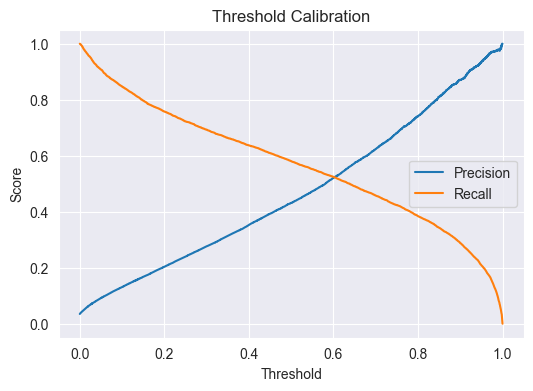

   threshold  precision  recall
0   0.000001   0.034991     1.0
1   0.000003   0.034991     1.0
2   0.000003   0.034991     1.0
3   0.000003   0.034991     1.0
4   0.000003   0.034991     1.0


In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_true, y_proba)
# Plot
plt.figure(figsize=(6,4))
plt.plot(thr, prec[:-1], label='Precision')
plt.plot(thr, rec[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Calibration')
plt.legend()
plt.grid(True)
plt.show()

# Display sample thresholds
df_thr = pd.DataFrame({'threshold': thr, 'precision': prec[:-1], 'recall': rec[:-1]})
print(df_thr.sort_values(by='f1', ascending=False).head(5) if 'f1' in df_thr else df_thr.head(5))

## 3.5 Serialize Inference Pipeline / 序列化推断管道

- Save the `predict_fraud` function’s dependencies and model so a single pipeline object can be deployed.

In [51]:
# 3.5 Serialize Inference Pipeline / 序列化推断管道
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
import pandas as pd

# -- 1) Reload 原始数据并切分（只为 preprocessor.fit 准备训练集） --
df_tr = pd.read_csv('Data/train_transaction.csv')
df_id = pd.read_csv('Data/train_identity.csv')
df_all = pd.merge(df_tr, df_id, on='TransactionID', how='left').drop(columns=['TransactionID','isFraud'])
_, df_train_raw = train_test_split(  # 只取训练集部分
    pd.merge(df_tr, df_id, on='TransactionID', how='left').drop(columns=['TransactionID']),
    test_size=0.3,
    random_state=42,
    stratify=pd.merge(df_tr, df_id, on='TransactionID', how='left')['isFraud']
)

# -- 2) 定义预处理器（与前面一致） --
def impute_and_scale(X):
    return scaler.transform(num_imp.transform(X[num_cols]))

def encode_cat(X):
    return cat_enc.transform(X[cat_cols]) if cat_enc else X

preprocessor = ColumnTransformer(transformers=[
    ('num', FunctionTransformer(impute_and_scale, validate=False), num_cols),
    ('cat', FunctionTransformer(encode_cat,      validate=False), cat_cols)
], remainder='drop')

# -- 3) 用训练集特征 “拟合” preprocessor --
preprocessor.fit(df_train_raw[feature_names])


# -- 4) 构建完整 Pipeline（此时 preprocessor 已拟合，xgb_model 也已训练） --
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf',     xgb_model)
])

# -- 5) 序列化 --
joblib.dump(pipeline, 'fraud_inference_pipeline.pkl')
print("Saved full inference pipeline as fraud_inference_pipeline.pkl")

/Users/ssa10566/PycharmProjects/Datamining1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Saved full inference pipeline as fraud_inference_pipeline.pkl


## 3.6

In [52]:
pipeline = joblib.load('fraud_inference_pipeline.pkl')
proba    = pipeline.predict_proba(df_new)[:,1]
pred     = (proba >= 0.5).astype(int)

/Users/ssa10566/PycharmProjects/Datamining1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
